# Análise de Redes de Citações Acadêmicas (em português)

**Descrição:**  
Construir grafos com autores ou artigos como nós e as arestas representando citações. Pode ser aplicado a pesquisas brasileiras.  
**Objetivos:**  
Mapear áreas de conhecimento mais conectadas.  
Verificar autores ou instituições mais citadas.  
**Bibliotecas:**  
- Collections
- Matplotlib
- Networkx
- Numpy
- Pandas
- Requests

### Importando bibliotecas

In [ ]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import Counter

### Função que coleta artigos da API OpenAlex

In [ ]:
def coletar_openalex(query, n=5):
    # Montando url de requisição com o número de artigos por página
    url = f"https://api.openalex.org/works?filter=title.search:{query}&per-page={n}"
    # Requisição HTTP obtém um json
    data = requests.get(url).json()
    artigos = []
    for item in data.get("results", []):
        autores = [a["author"]["display_name"] for a in item.get("authorships", []) if a.get("author")]
        referencias = item.get("referenced_works", [])
        conceitos = [c["display_name"] for c in item.get("concepts", [])]
        artigos.append({
            "id": item["id"],
            "titulo": item["title"],
            "ano": item.get("publication_year"),
            "autores": autores,
            "citacoes": item.get("cited_by_count", 0),
            "referencias": referencias,
            "conceitos": conceitos
        })
    return pd.DataFrame(artigos)

### Função que busca autores citados dos artigos

In [ ]:
def buscar_autores_citados(ids):
    autores_citados = {}
    batch_size = 20
    for i in range(0, len(ids), batch_size):
        subset = ids[i:i+batch_size]
        url = f"https://api.openalex.org/works?filter=ids.openalex:{'|'.join(subset)}&per-page=50"
        data = requests.get(url).json()
        # Para cada artigo retornado guarda os nomes dos autores
        for item in data.get("results", []):
            autores = [a["author"]["display_name"] for a in item.get("authorships", []) if a.get("author")]
            autores_citados[item["id"]] = autores
    return autores_citados

### Coletando artigos e criando primeiro grafo

In [ ]:
df = coletar_openalex("inteligência artificial Brasil", n=30)
print("Artigos coletados:", len(df))

todos_ids_citados = set(sum(df["referencias"].tolist(), []))
autores_citados = buscar_autores_citados(list(todos_ids_citados))

G = nx.DiGraph()
for _, row in df.iterrows():
    # Considera apenas o primeiro autor para construção do grafo, limite colocado para diminuir os nós
    autores_que_citam = row["autores"][:1]
    for ref in row["referencias"]:
        if ref in autores_citados:
            # Considera apenas o primeiro autor citado para construção do grafo
            autores_alvo = autores_citados[ref][:1]
            for a1 in autores_que_citam:
                for a2 in autores_alvo:
                    if a1 != a2:
                        if G.has_edge(a1, a2):
                            G[a1][a2]["weight"] += 1
                        else:
                            G.add_edge(a1, a2, weight=1)

print(f"Nós (autores): {G.number_of_nodes()} | Arestas (citações): {G.number_of_edges()}")

Artigos coletados: 30
Nós (autores): 194 | Arestas (citações): 179


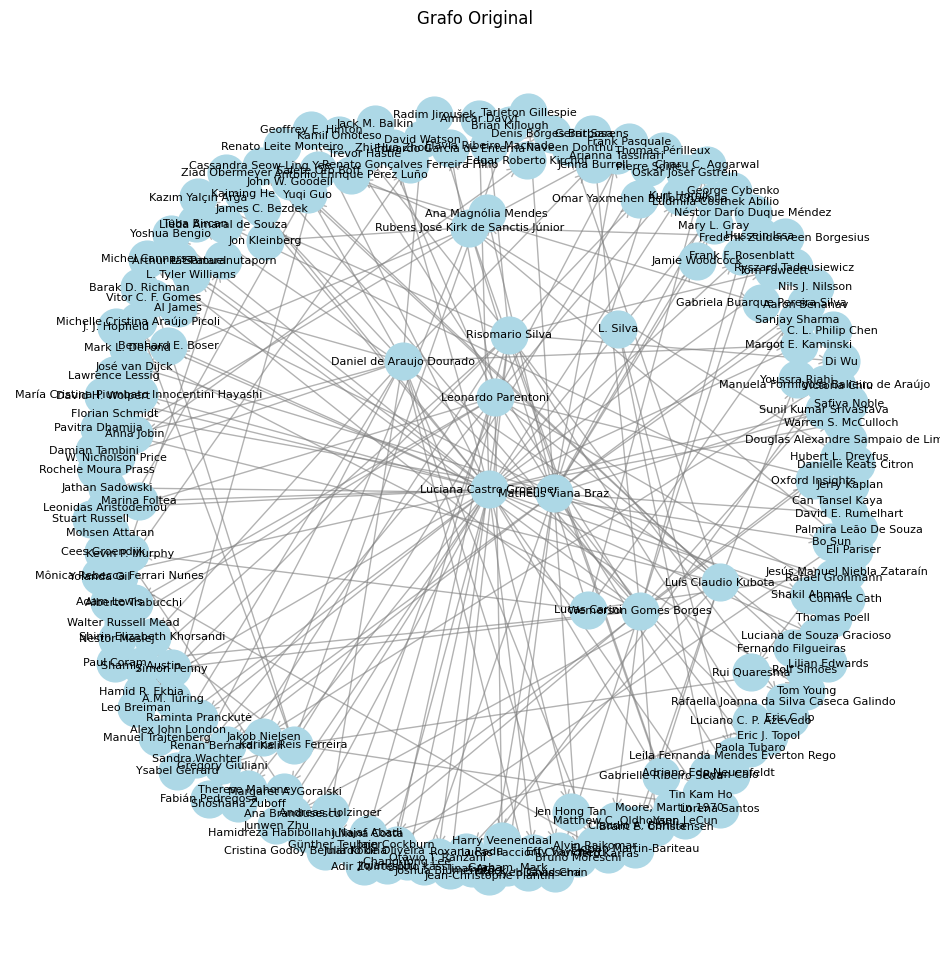

In [ ]:
# Criando a imagem do grafo original para plotar
plt.figure(figsize=(12, 12))
pos_G = nx.spring_layout(G, seed=42, k=1.2)
nx.draw_networkx_nodes(G, pos_G, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(G, pos_G, arrowstyle="->", arrowsize=15, edge_color="gray", alpha=0.6)
nx.draw_networkx_labels(G, pos_G, font_size=8)

plt.title("Grafo Original")
plt.axis("off")
plt.show()

### Rankings de autores mais citados e áreas de conhecimento mais presente

In [ ]:
citacoes_autor = dict(G.in_degree(weight="weight"))
ranking = sorted(citacoes_autor.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nAutores mais citados:")
for nome, qtd in ranking:
    print(f"{nome:30s} | {qtd}")

todas_conceitos = sum(df["conceitos"].tolist(), [])

ranking_conceitos = Counter(todas_conceitos).most_common(10)
print("\nÁreas mais frequentes (conceitos dos artigos analisados):")
for area, freq in ranking_conceitos:
    print(f"{area:30s} | {freq}")


Autores mais citados:
Ludmila Costhek Abílio         | 3
Sandra Wachter                 | 2
Yann LeCun                     | 2
Frank Pasquale                 | 2
Rafael Grohmann                | 2
Lorena Santos                  | 2
Vitor C. F. Gomes              | 2
Margot E. Kaminski             | 1
Barak D. Richman               | 1
Jenna Burrell                  | 1

Áreas mais frequentes (conceitos dos artigos analisados):
Philosophy                     | 22
Humanities                     | 21
Political science              | 13
Computer science               | 6
Physics                        | 5
Artificial intelligence        | 3
Medicine                       | 3
Psychology                     | 3
Art                            | 2
Economics                      | 2


### Criando segundo grafo filtrado com os autores mais relevantes

In [ ]:
top_autores = [nome for nome, _ in ranking]

H = nx.DiGraph()
for autor_citado in top_autores:
    for autor_citante in G.predecessors(autor_citado):
        if G.has_edge(autor_citante, autor_citado):
            peso = G[autor_citante][autor_citado].get("weight", 1)
        else:
            peso = 1
        H.add_node(autor_citado, tipo="citado")
        H.add_node(autor_citante, tipo="citante")
        H.add_edge(autor_citante, autor_citado, autor_top=autor_citado, weight=peso)

print(f"Nós (autores): {H.number_of_nodes()} | Arestas (citações): {H.number_of_edges()}")

node_colors_H = [
    "lightgreen" if H.nodes[n]["tipo"] == "citado" else "lightblue"
    for n in H.nodes()
]

# Cria uma paleta de cores para as arestas com base nos autores mais citados
cores = cm.tab10(np.linspace(0, 1, len(top_autores)))
cor_aresta_map = {autor: cores[i] for i, autor in enumerate(top_autores)}

# Define a cor de cada aresta de acordo com o autor correspondente
edge_colors_H = [cor_aresta_map[H.edges[e]["autor_top"]] for e in H.edges()]
# Define a espessura da aresta de acordo com quantas vezes o autor é citado
edge_weights = [1 + np.log1p(H.edges[e]["weight"]) * 2 for e in H.edges()]

Nós (autores): 16 | Arestas (citações): 12


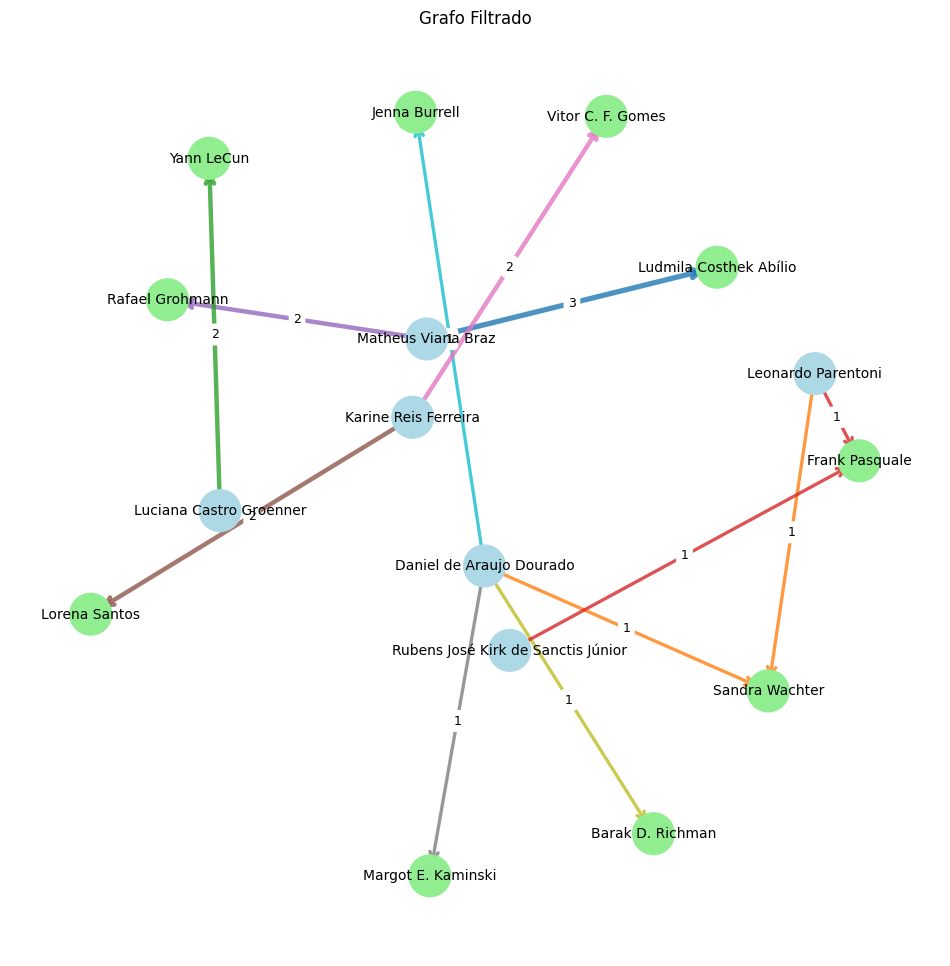

In [ ]:
# Criando a imagem do grafo filtrado para plotar
plt.figure(figsize=(12, 12))
pos_H = nx.spring_layout(H, seed=28, k=1.2)
nx.draw_networkx_nodes(H, pos_H, node_size=900, node_color=node_colors_H)
nx.draw_networkx_edges(
    H, pos_H, arrowstyle="->", arrowsize=15,
    edge_color=edge_colors_H, width=edge_weights, alpha=0.8
)
nx.draw_networkx_labels(H, pos_H, font_size=10)
edge_labels = nx.get_edge_attributes(H, "weight")
nx.draw_networkx_edge_labels(
    H, pos_H, edge_labels=edge_labels, font_color="black", font_size=9, rotate=False
)

plt.title("Grafo Filtrado")
plt.axis("off")
plt.show()